Importing all the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Uploading files from local

Top five view of dataset

In [2]:
AUDUSD=pd.read_csv('/path_will_come/AUDUSD.csv')
AUDUSD.head() 

,Time (UTC),Open,High,Low,Close,Volume
0,2010.01.01 02:00:00,0.89748,0.89759,0.89741,0.89747,7951.85
1,2010.01.01 06:00:00,0.89747,0.89763,0.89739,0.89754,18505.45
2,2010.01.01 10:00:00,0.89755,0.89763,0.89746,0.89750,15265.53
3,2010.01.01 14:00:00,0.89753,0.89769,0.89746,0.89753,16587.97
4,2010.01.01 18:00:00,0.89755,0.89765,0.89738,0.89738,7615.19


Bottom view of dataset

In [3]:
AUDUSD.tail() 
 

,Time (UTC),Open,High,Low,Close,Volume
15895,2020.03.12 05:00:00,0.64578,0.64638,0.64352,0.64362,31186.71
15896,2020.03.12 09:00:00,0.64362,0.64365,0.63481,0.63487,36624.52
15897,2020.03.12 13:00:00,0.63487,0.63678,0.62669,0.63544,72771.41
15898,2020.03.12 17:00:00,0.63543,0.63866,0.62136,0.62377,55018.52
15899,2020.03.12 21:00:00,0.62378,0.63186,0.62336,0.62899,27747.49


Here we have target value of column **'High'**.

In [4]:
data=AUDUSD['High']
data.head() 

0    0.89759
1    0.89763
2    0.89763
3    0.89769
4    0.89765
Name: High, dtype: float64

Data shape

In [5]:
data.shape

(15900,)

Graph ploting

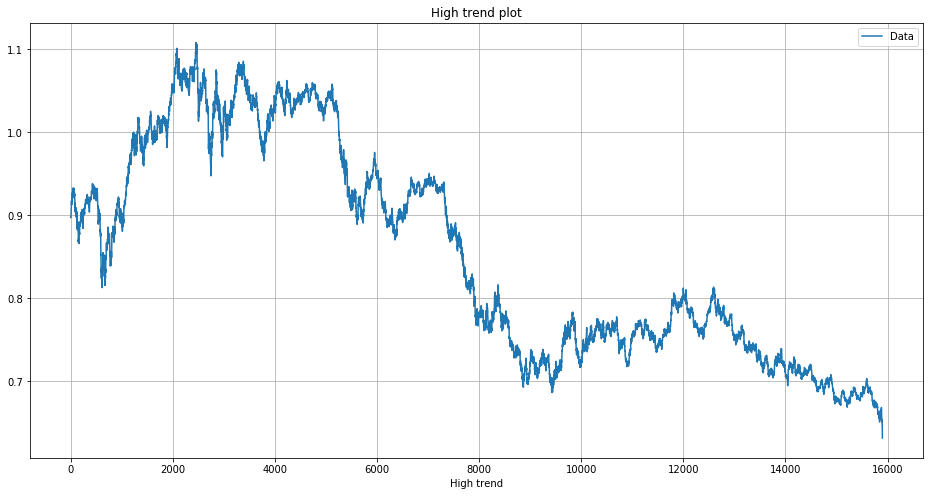

In [6]:
plt.figure(figsize=(16,8)) 
plt.plot(data) 
plt.legend(['Data'])
plt.title('High trend plot')
plt.xlabel('High trend')
plt.grid()
plt.show()

Train and test size determination:



In [7]:
def split_set(data,time_steps):
    split_X=[]
    split_y=[]
    split=[[data[j+i] for j in range(time_steps)] for i in range(len(data)-time_steps)]
    split_X=split
    
    for i in range(len(data)-time_steps):
        split_y.append([data[i+time_steps]])
    return np.array(split_X),np.array(split_y)

Method for creating data set

In [8]:
time_steps=1
dataX,dataY=split_set(data,time_steps)


train_size=int(len(dataX)*0.80)
test_size=len(dataX)-train_size

print('Train-size=',train_size)
print('Test-size=',test_size)


trainX=dataX[0:train_size,]
trainY=dataY[0:train_size,]


testX=dataX[train_size:len(data),]
testY=dataY[train_size:len(data),]



Train-size= 12719
Test-size= 3180


Data shape

In [9]:

trainX=trainX.reshape(trainX.shape[0],time_steps,1)
testX=testX.reshape(testX.shape[0],time_steps,1)
print('TrainX=',trainX.shape)
print('TrainY=',trainY.shape)


TrainX= (12719, 1, 1)
TrainY= (12719, 1)


Now from here we see author proposed model. To deal with some previous time series with null.

In [10]:
previous_input=np.zeros(trainX.shape[0]).reshape(trainX.shape[0],1,time_steps)
previous_input.shape

(12719, 1, 1)

Here we are finding the difference formula proposed by author. In DA-
LSTM, we extract the difference feature
$$diff=[(x_t-x_{t-2})^2,(x_t-x_{t-1})^2]$$
to measure the input time series variation

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,LSTM,TimeDistributed,Input,concatenate,Concatenate
from tensorflow.keras.models import Model,Sequential

d1=np.zeros(trainX.shape[0]).reshape(trainX.shape[0],1,1)
d2=np.zeros(trainX.shape[0]).reshape(trainX.shape[0],1,1)
y=data

for i in range(trainX.shape[0]):
  if i==0:
    d1[i]=0
    d2[i]=y[i]**2
  elif i==1:
    d1[i]=y[i-1]**2
    d2[i]=(y[i]-y[i-1])**2
  else:
    d1[i]=(y[i-1]-y[i-2])**2
    d2[i]=(y[i]-y[i-1])**2

x1=Input(shape=(trainX.shape[0],1,1 ))
x2=Input(shape=(trainX.shape[0],1 ,1))

#y1=concatenate([x1,x2],axis=-1)
y1=Concatenate(axis=-1)([x1, x2])

model=Model([x1,x2],y1)
model.predict([[d1],[d2]])
model.summary()
diff=np.concatenate([d1,d2],axis=-1)
#diff=Concatenate(axis=-1)([d1,d2])
diff


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12719, 1, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 12719, 1, 1)  0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 12719, 1, 2)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
Total params: 0
Trainable params: 0
Non-trainable params: 0
__________________________________________________________________________________________________


array([[[0.00000000e+00, 8.05667808e-01]],

       [[8.05667808e-01, 1.60000000e-09]],

       [[1.60000000e-09, 0.00000000e+00]],

       ...,

       [[2.22010000e-06, 2.16090000e-06]],

       [[2.16090000e-06, 6.76000000e-06]],

       [[6.76000000e-06, 2.50000000e-07]]])

In [12]:
print(y1.shape)
print(diff .shape)

(?, 12719, 1, 2)
(12719, 1, 2)


# Here all the formula proposed in research paper step by step explanation

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,LSTM,RepeatVector,Input,Concatenate,Multiply,Lambda,Dot,Activation,Flatten,dot
from tensorflow.keras.models import Model
from keras import backend as K

#import keras
encoder_input=Input(shape=(time_steps,1))
encoder_output=LSTM(20,return_sequences=True)(encoder_input)
print(encoder_output.shape)

model=Model(encoder_input,encoder_output)
hidden_output=model.predict([trainX,trainY])
print(hidden_output.shape)
print(type(hidden_output))

(?, 1, 20)
(12719, 1, 20)
<class 'numpy.ndarray'>


concatinating hidden_output with diff

In [18]:
concatenation=np.concatenate([hidden_output,diff],axis=-1)
print(concatenation)
print(type(concatenation))
print(concatenation.shape)

#print((concatenation).reshape(12719*22)[0:20])
#print(type(concatenation.reshape(279818)))

[[[ 3.91883738e-02 -1.49229234e-02  1.46198533e-02 ... -1.21895792e-02
    0.00000000e+00  8.05667808e-01]]

 [[ 3.91899459e-02 -1.49236489e-02  1.46204829e-02 ... -1.21901557e-02
    8.05667808e-01  1.60000000e-09]]

 [[ 3.91899459e-02 -1.49236489e-02  1.46204829e-02 ... -1.21901557e-02
    1.60000000e-09  0.00000000e+00]]

 ...

 [[ 3.48139480e-02 -1.29588917e-02  1.28885470e-02 ... -1.06152361e-02
    2.22010000e-06  2.16090000e-06]]

 [[ 3.47087756e-02 -1.29128201e-02  1.28473239e-02 ... -1.05782058e-02
    2.16090000e-06  6.76000000e-06]]

 [[ 3.47290002e-02 -1.29216779e-02  1.28552495e-02 ... -1.05853258e-02
    6.76000000e-06  2.50000000e-07]]]
<class 'numpy.ndarray'>
(12719, 1, 22)


Applying softmax function

In [20]:
a1=concatenation.reshape(279818)
#print(a1)
x1=Input(shape=(279818,))
y1=Activation('softmax')(x1)
model2=Model([x1],y1)
alpha_t=model2.predict([[a1]])
print(model2.predict([[a1]]))

[[3.7398927e-06 3.5428998e-06 3.6491283e-06 ... 3.5583012e-06
  3.5961909e-06 3.5961677e-06]]


Taking dot product

In [21]:
h_t=a1.reshape(12719, 1, 22)
alpha_t=alpha_t.reshape(12719, 1, 22)

x2=Input(shape=(12719,1,22))
x3=Input(shape=(12719,1,22))

y1=dot([x2,x3],axes=3)
model3=Model([x2,x3],y1)
mul=model3.predict([[alpha_t],[h_t]])

mul.shape


(1, 12719, 1, 1)

Summation of dot product

In [25]:
net=mul
net_input=Input(shape=(12719,1,1))
summation=Lambda(lambda mul: K.sum(mul, axis=2))(net_input)
test_model=Model(net_input,summation)
summation=test_model.predict(mul)
print(summation)

[[[ 6.0229245e-06]
  [ 6.0229045e-06]
  [-4.6184093e-07]
  ...
  [-4.0722176e-07]
  [-4.0590365e-07]
  [-4.0616084e-07]]]


In [26]:
summation.shape

(1, 12719, 1)

In [27]:
summation=summation.reshape(12719,1,1)
summation

array([[[ 6.0229245e-06]],

       [[ 6.0229045e-06]],

       [[-4.6184093e-07]],

       ...,

       [[-4.0722176e-07]],

       [[-4.0590365e-07]],

       [[-4.0616084e-07]]], dtype=float32)

In [28]:
summation.shape

(12719, 1, 1)

DA_lstm model

In [29]:
dense_input=Input(shape=(1,1))

dense_output=(Dense(1))(dense_input)
da_lstm=Model(dense_input,dense_output)
da_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 1, 1)              0         
_________________________________________________________________
dense (Dense)                (None, 1, 1)              2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


loss function used by author

In [32]:
def custom_loss(y_true, y_pred):
    return K.mean(y_true - y_pred)**2

da_lstm.compile(loss=custom_loss,optimizer='adam')
da_lstm.fit((trainX),(trainY), epochs=2,batch_size=64)

Epoch 1/2
12719/12719 [==============================] - 1s 47us/sample - loss: 6.2274e-04
Epoch 2/2
12719/12719 [==============================] - 0s 31us/sample - loss: 1.3097e-05


Preiction over test data

In [58]:
prediction_testX=da_lstm.predict(testX)
prediction_testX

array([[[0.809259  ]],

       [[0.8089845 ]],

       [[0.8081768 ]],

       ...,

       [[0.6969218 ]],

       [[0.69153476]],

       [[0.69300896]]], dtype=float32)

In [59]:
prediction_testX.shape

(3180, 1, 1)

In [61]:
testY.reshape(prediction_testX.shape[0], 1, 1).shape

(3180, 1, 1)

# Error correction LSTM

In [63]:
difference=testY.reshape(prediction_testX.shape[0], 1, 1)-prediction_testX
difference

array([[[-0.022699  ]],

       [[-0.02345452]],

       [[-0.02345682]],

       ...,

       [[-0.06014183]],

       [[-0.05287476]],

       [[-0.06114896]]])

In [64]:
difference.shape

(3180, 1, 1)

In [66]:
error=difference.reshape(prediction_testX.shape[0], 1)
error

array([[-0.022699  ],
       [-0.02345452],
       [-0.02345682],
       ...,
       [-0.06014183],
       [-0.05287476],
       [-0.06114896]])

In [67]:
time_steps=1
error_dataX,error_dataY=split_set(error,time_steps)


error_train_size=int(len(error_dataX)*0.80)
error_test_size=len(error_dataX)-error_train_size

print('Train-size=',error_train_size)
print('Test-size=',error_test_size)


error_trainX=error_dataX[0:error_train_size,]
error_trainY=error_dataY[0:error_train_size,]


error_testX=error_dataX[error_train_size:len(error),]
error_testY=error_dataY[error_train_size:len(error),]




error_trainX=error_trainX.reshape(error_trainX.shape[0],time_steps,1)
error_testX=error_testX.reshape(error_testX.shape[0],time_steps,1)
print('Error TrainX=',error_trainX.shape)
print('Error TrainY=',error_trainY.shape)

Train-size= 2543
Test-size= 636
Error TrainX= (2543, 1, 1)
Error TrainY= (2543, 1, 1)


In [70]:
error_trainY=error_trainY.reshape(error_trainY.shape[0],1)

ec model

In [71]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,LSTM,Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1, l2, l1_l2

error_encoder_input_shape=Input(shape=(1,1))
encoder_lstm1=LSTM(40,return_sequences=True)(error_encoder_input_shape)
encoder_lstm2=LSTM(40)(encoder_lstm1)
dense1=Dense(20)(encoder_lstm2)
output=Dense(1,kernel_regularizer=l2(2e-4))(dense1)
ec_lstm=Model(error_encoder_input_shape,output)
ec_lstm.summary()

def custom_loss(y_true, y_pred):
    return K.mean(y_true - y_pred)**2

ec_lstm.compile(loss=custom_loss,optimizer='adam')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 1, 1)              0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 40)             6720      
_________________________________________________________________
lstm_5 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 20,521
Trainable params: 20,521
Non-trainable params: 0
_________________________________________________________________


Model fitting

In [72]:
ec_lstm.fit(error_trainX,error_trainY,epochs=2)

Epoch 1/2
2543/2543 [==============================] - 4s 1ms/sample - loss: 4.7382e-04
Epoch 2/2
2543/2543 [==============================] - 0s 139us/sample - loss: 2.9934e-04


All prediction values

In [73]:
EC_trainX=ec_lstm.predict(error_trainX)
EC_trainX

array([[-0.0366268 ],
       [-0.03663317],
       [-0.03663318],
       ...,
       [-0.03682161],
       [-0.03681433],
       [-0.03683054]], dtype=float32)

In [74]:
EC_testX=ec_lstm.predict(error_testX)
EC_testX

array([[-0.03683005],
       [-0.03682299],
       [-0.036832  ],
       [-0.03682549],
       [-0.03684181],
       [-0.03682431],
       [-0.03683019],
       [-0.03681007],
       [-0.03682556],
       [-0.03680328],
       [-0.03681861],
       [-0.03680775],
       [-0.03679427],
       [-0.03681419],
       [-0.03681444],
       [-0.03680985],
       [-0.03680713],
       [-0.03680795],
       [-0.03680589],
       [-0.03680573],
       [-0.03680382],
       [-0.03680773],
       [-0.03680152],
       [-0.03679462],
       [-0.03680339],
       [-0.03680439],
       [-0.03681221],
       [-0.03679867],
       [-0.03679977],
       [-0.0368049 ],
       [-0.03681731],
       [-0.03680258],
       [-0.03680501],
       [-0.03681194],
       [-0.03680861],
       [-0.0368174 ],
       [-0.03680837],
       [-0.0368094 ],
       [-0.03680269],
       [-0.03680886],
       [-0.03680689],
       [-0.0368154 ],
       [-0.03681274],
       [-0.03681244],
       [-0.03682683],
       [-0

combining all the vectors

In [100]:
EC_train=np.hstack([EC_trainX.reshape(EC_trainX.shape[0]),EC_testX.reshape(EC_testX.shape[0]),ec_lstm.predict(error_testY)[635]])
EC_train

array([-0.0366268 , -0.03663317, -0.03663318, ..., -0.0369424 ,
       -0.03688116, -0.03695089], dtype=float32)

In [101]:
EC_train.shape

(3180,)

In [77]:
DA_trainX=da_lstm.predict(trainX)
DA_trainX

array([[[0.89604855]],

       [[0.8960799 ]],

       [[0.8960799 ]],

       ...,

       [[0.8100196 ]],

       [[0.80798084]],

       [[0.8083729 ]]], dtype=float32)

In [78]:
DA_trainX.shape

(12719, 1, 1)

In [79]:
(DA_trainX+EC_train)

array([[[0.85942173, 0.85941535, 0.85941535, ..., 0.859146  ,
         0.8591061 , 0.8591674 ]],

       [[0.8594531 , 0.8594467 , 0.8594467 , ..., 0.85917735,
         0.8591375 , 0.85919875]],

       [[0.8594531 , 0.8594467 , 0.8594467 , ..., 0.85917735,
         0.8591375 , 0.85919875]],

       ...,

       [[0.7733928 , 0.7733864 , 0.7733864 , ..., 0.77311707,
         0.7730772 , 0.77313846]],

       [[0.771354  , 0.77134764, 0.77134764, ..., 0.7710783 ,
         0.7710384 , 0.7710997 ]],

       [[0.7717461 , 0.7717397 , 0.7717397 , ..., 0.77147037,
         0.7714305 , 0.77149177]]], dtype=float32)

In [80]:
EC_testX=ec_lstm.predict(error_testX)
print(EC_testX)
EC_testX.shape

[[-0.03683005]
 [-0.03682299]
 [-0.036832  ]
 [-0.03682549]
 [-0.03684181]
 [-0.03682431]
 [-0.03683019]
 [-0.03681007]
 [-0.03682556]
 [-0.03680328]
 [-0.03681861]
 [-0.03680775]
 [-0.03679427]
 [-0.03681419]
 [-0.03681444]
 [-0.03680985]
 [-0.03680713]
 [-0.03680795]
 [-0.03680589]
 [-0.03680573]
 [-0.03680382]
 [-0.03680773]
 [-0.03680152]
 [-0.03679462]
 [-0.03680339]
 [-0.03680439]
 [-0.03681221]
 [-0.03679867]
 [-0.03679977]
 [-0.0368049 ]
 [-0.03681731]
 [-0.03680258]
 [-0.03680501]
 [-0.03681194]
 [-0.03680861]
 [-0.0368174 ]
 [-0.03680837]
 [-0.0368094 ]
 [-0.03680269]
 [-0.03680886]
 [-0.03680689]
 [-0.0368154 ]
 [-0.03681274]
 [-0.03681244]
 [-0.03682683]
 [-0.0368144 ]
 [-0.03681554]
 [-0.03680378]
 [-0.03681311]
 [-0.03680926]
 [-0.0368203 ]
 [-0.03681348]
 [-0.03681456]
 [-0.03681123]
 [-0.03680832]
 [-0.03680677]
 [-0.03680653]
 [-0.03681121]
 [-0.03680194]
 [-0.03680368]
 [-0.03680669]
 [-0.03679776]
 [-0.03680986]
 [-0.03680379]
 [-0.03680343]
 [-0.03680344]
 [-0.03680

(636, 1)

In [81]:
DA_testX=da_lstm.predict(testX)
DA_testX
print(DA_testX)
DA_testX.shape

[[[0.809259  ]]

 [[0.8089845 ]]

 [[0.8081768 ]]

 ...

 [[0.6969218 ]]

 [[0.69153476]]

 [[0.69300896]]]


(3180, 1, 1)

In [102]:
EC_train.shape

(3180,)

Preducted test from model

In [106]:
predicted_test=EC_train+DA_testX.reshape(3180)
predicted_test

array([0.7726322, 0.7723513, 0.7715436, ..., 0.6599794, 0.6546536,
       0.6560581], dtype=float32)

# plot

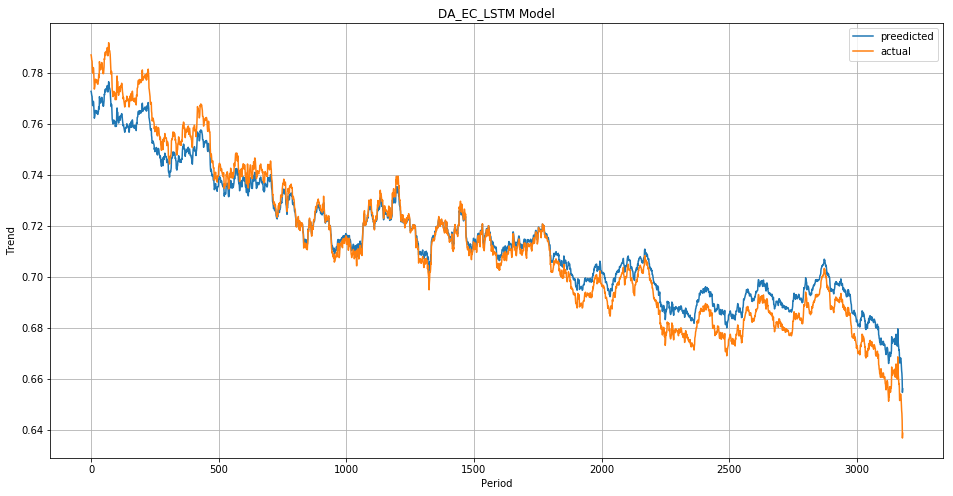

In [114]:
plt.figure(figsize=(16,8))
plt.title('DA_EC_LSTM Model')
plt.ylabel('Trend')
plt.xlabel('Period')
plt.plot(predicted_test)
plt.plot(testX.reshape(3180))
plt.legend(['preedicted','actual'])
plt.grid()
plt.show()

# Metric measure

In [115]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100


RMSE=np.sqrt(np.mean(((predicted_test- testY)**2)))

SMAPE=(np.sum(2*np.abs(predicted_test- testY)/((np.abs(predicted_test)+ np.abs(testY))))*100)/len(testY)


print('MSE:',mean_squared_error(predicted_test,testY))
print('MAE:',mean_absolute_error(predicted_test,testY))
print('RMSE:',RMSE)
print('SMAPE:',SMAPE)
print('MAPE:',mape(testY,predicted_test ))


MSE: 4.674239625314063e-05
MAE: 0.005683573761238242
RMSE: 0.038816489087508975
SMAPE: 13796.771436573685
MAPE: 4.351726352313755


# Conclusion

1.It works very well in middel period. As we can see in above graph.

2.But it is effective model once we get suitable weights.
